# Create Environment

In [85]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from tqdm import tqdm

global N

N=100

global T
global target
T=20
target=np.array([3,2])
global w
w=np.pi*2/23.7

global delta_t
delta_t=T/N

global beta
beta=[0.95,0.975,1,1.025,1.05]

global num_system
num_system=5

In [86]:
def Z(vecs, u, v):
    output=[]
    for i in range(num_system):
        vec=vecs[i]
        x=vec[0]
        y=vec[1]
        theta=vec[2]
        output.append([beta[i]*np.cos(theta)*u,beta[i]*np.sin(theta)*u,beta[i]*v])
    return np.array(output)

#check the correctness of Z
'''
x = np.linspace(0, 6.5, 1001)
plt.plot(x, Z(x))
plt.xlabel('Angle [rad]')
plt.ylabel('Z(theta)')
plt.grid()
plt.show()
'''

"\nx = np.linspace(0, 6.5, 1001)\nplt.plot(x, Z(x))\nplt.xlabel('Angle [rad]')\nplt.ylabel('Z(theta)')\nplt.grid()\nplt.show()\n"

In [87]:
def next_step(vecs,action):
    vecs_new=[]
    u=action[0]
    v=action[1]
    diff=Z(vecs,u,v)
    for i in range(num_system):
        w=vecs[i]+delta_t*diff[i]
        
        '''
        if w[2]>np.pi:
            w[2]-=2*np.pi
        if w[2]<-np.pi:
            w[2]+=2*np.pi
        '''
        
        vecs_new.append(w)
    return np.array(vecs_new)

def observe(vecs):
    mu_x=0
    mu_y=0
    mu_theta=0
    var_x=0
    var_y=0
    for i in range(num_system):
        mu_x+=vecs[i][0]
        mu_y+=vecs[i][1]
        mu_theta+=vecs[i][2]
        var_x+=vecs[i][0]**2
        var_y+=vecs[i][1]**2
    var_x-=mu_x**2/num_system
    var_y-=mu_y**2/num_system
    
    w=np.array([mu_x,mu_y,mu_theta,var_x,var_y])/num_system
    '''
    if w[2]>np.pi:
        w[2]-=2*np.pi
    if w[2]<-np.pi:
        w[2]+=2*np.pi
    '''
    return w

def reward(obs):
    return max(100-(obs[0]-target[0])**2-(obs[1]-target[1])**2-obs[3]-obs[4],0)

# Learning Settings

In [88]:
global lr
lr=0.7
global eps
eps=0.1
global max_u
max_u=2
global precision
precision=0.0002
global action_set
action_set=np.array([[1,np.pi/4],[-1,np.pi/4],[1,0],[-1,0],[1,-np.pi/4],[-1,-np.pi/4]])

def exploration():
    a=np.random.uniform()
    if a<eps:
        return True
    else:
        return False

def find_max(cand):
    return np.argmax(cand)
    
def decide_u(theta,cand,init=False):
    explo=exploration()
    if init or explo:
        return(np.random.randint(6)), True
    else:
        return(find_max(cand)), False
    
def generate_history_pred(gp_list,history):
    cand=[]
    for j in range(len(gp_list)):
        pred=gp_list[j].predict(history.reshape(-1,5), return_std=False).reshape(-1,1)
        if j==0:
            cand=pred
        else:
            cand=np.concatenate((cand,pred),axis=1)
    output=[]
    for j in range(history.shape[0]):
        output.append([np.max(cand[j])])
    return np.array(output)
        
    
def decide_u_exploitation(theta,cand,init=False):
    return find_max(cand)


def trainingset_refine(history_su,history_su_next, history_r, num=1000):
    if history_su.shape[0]<num:
        return history_su, history_su_next, history_r
    else:
        history_su=history_su[-num:-1]
        history_su_next=history_su_next[-num:-1]
        history_r=history_r[-num:-1]
        return history_su,history_su_next,history_r


history_su=[0 for i in range(6)]
history_r=[0 for i in range(6)]
history_su_next=[0 for i in range(6)]
flags=[True for i in range(6)]

# Simulation


In [89]:
num_iter=80

position_result=[]
observation_result=[]
gpr_list=[]

best_r=-10000
best_obs=[]
best_pos=[[] for i in range(5)]

for iterr in tqdm(range(num_iter)):
    #initialize
    position=np.array([[-2,-2,0],[-2,-2,0],[-2,-2,0],[-2,-2,0],[-2,-2,0]])
    observation=observe(position)
    u_t=[]
    observation_t=[observation]
    position_t=[[] for i in range(5)]
    
    for time in range(N+1):
        if iterr==0:
            candidates_u=[]
            u_k, _ = decide_u(observation,candidates_u,init=True)
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            
            if flags[u_k]:
                history_su[u_k] = observation.reshape(-1,5)
                history_su_next[u_k] = observation_new.reshape(-1,5)  
                history_r[u_k] = np.array([r])
                flags[u_k]=False
            else:
                history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
                history_su_next[u_k] = np.concatenate((history_su_next[u_k], observation_new.reshape(-1,5)))
                history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            
        else:            
            candidates_u=[]
            for i in range(6):
                cand, _ = gpr_list[i].predict(observation.reshape(-1,5), return_std=True)
                candidates_u.append(cand[0])
            #print(candidates_u)
            u_k, explo = decide_u(observation,np.array(candidates_u))
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            if r>0.1:
                if explo:
                    history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
                    history_su_next[u_k] = np.concatenate((history_su_next[u_k], observation_new.reshape(-1,5)))
                    history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
                else:
                    a=np.random.uniform()
                    if a<0.25:
                        history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
                        history_su_next[u_k] = np.concatenate((history_su_next[u_k], observation_new.reshape(-1,5)))
                        history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            if time%((N+1)//3+1)==0:
                for i in range(6):
                    history_target=history_r[i].reshape(-1,1)+0.2*generate_history_pred(gpr_list,history_su_next[i])
                    gpr_list[i]=GaussianProcessRegressor(alpha=1e-4).fit(history_su[i], history_target)
                
                '''
                for i in range(6):
                    hist_su, hist_su_next, hist_r = trainingset_refine(history_su[i],history_su_next[i], history_r[i])
                    history_target=hist_r.reshape(-1,1)+0.01*generate_history_pred(gpr_list,hist_su_next)
                    gpr_list[i]=GaussianProcessRegressor(alpha=1e-4).fit(hist_su, history_target)
                '''
     
            if r>100-0.03:
                break
            
    if iterr==0:
        for i in range(6):
            gpr_list.append(GaussianProcessRegressor(alpha=1e-4).fit(history_su[i], history_r[i].reshape(-1,1)))
    else:       
        for i in range(6):
            history_target=history_r[i].reshape(-1,1)+0.2*generate_history_pred(gpr_list,history_su_next[i])
            gpr_list[i]=GaussianProcessRegressor(alpha=1e-4).fit(history_su[i], history_target)
            #print(history_su[i].shape[0])
        '''
        for i in range(6):
            hist_su, hist_su_next, hist_r = trainingset_refine(history_su[i],history_su_next[i], history_r[i])
            history_target=hist_r.reshape(-1,1)+0.01*generate_history_pred(gpr_list,hist_su_next)
            gpr_list[i]=GaussianProcessRegressor(alpha=1e-4).fit(hist_su, history_target)
            print(history_su[i].shape[0])
        '''
            
    print("observation =",observation)
    #print(observation_t)
    position_result.append(position)
    observation_result.append(observation)
    if r>best_r:
        best_r=r
        best_obs=observation_t
        best_pos=position_t
    
    #print(history_su.shape)
    #print(u_t)

  0%|                                                                                           | 0/80 [00:00<?, ?it/s]

observation = [ 6.99579615e-01 -1.57064665e+00 -1.72787596e+00  1.82838913e-02
  2.08892680e-04]


  2%|██                                                                                 | 2/80 [00:00<00:11,  7.04it/s]

observation = [-2.88403541e-01 -1.89646732e+00 -6.28318531e-01  2.97135603e-03
  6.26483647e-05]


  4%|███                                                                                | 3/80 [00:00<00:14,  5.40it/s]

observation = [ 4.86490091e+00 -4.33153195e+00  2.51327412e+00  1.42502117e-01
  6.76978736e-05]


  5%|████▏                                                                              | 4/80 [00:00<00:16,  4.73it/s]

observation = [ 4.98013148e+00  7.11070630e+00 -2.51327412e+00  7.77651677e-01
  1.71432431e-03]


  6%|█████▏                                                                             | 5/80 [00:01<00:16,  4.46it/s]

observation = [ 4.21901405e+00 -2.26664848e+00  7.85398163e-01  4.72982082e-02
  1.01057880e-04]


  8%|██████▏                                                                            | 6/80 [00:01<00:17,  4.26it/s]

observation = [ 1.57248173e+01 -1.87220686e+00 -1.88495559e+00  3.01439363e-01
  1.48227143e-03]


  9%|███████▎                                                                           | 7/80 [00:01<00:17,  4.19it/s]

observation = [16.1426911   1.10380346  0.31415927  0.3714723   0.04679035]


 10%|████████▎                                                                          | 8/80 [00:01<00:17,  4.07it/s]

observation = [ 3.59129146e+00 -1.78355629e+00  3.45575192e+00  6.22074294e-02
  8.33777123e-04]


 11%|█████████▎                                                                         | 9/80 [00:02<00:18,  3.90it/s]

observation = [ 4.45994247e+00  1.82127816e-01 -1.11022302e-17  3.65040382e-02
  2.20204475e-02]


 12%|██████████▎                                                                       | 10/80 [00:02<00:18,  3.75it/s]

observation = [3.96665265 1.0928173  0.4712389  0.01976488 0.04162686]


 14%|███████████▎                                                                      | 11/80 [00:02<00:18,  3.67it/s]

observation = [-1.27870158  2.21424508 -1.88495559  0.02282181  0.05292346]


 15%|████████████▎                                                                     | 12/80 [00:02<00:19,  3.51it/s]

observation = [ 0.35231653  0.17919193 -1.25663706  0.02037386  0.0162972 ]


 16%|█████████████▎                                                                    | 13/80 [00:03<00:20,  3.33it/s]

observation = [3.25470325 0.49005113 0.15707963 0.01509271 0.02534935]


 18%|██████████████▎                                                                   | 14/80 [00:03<00:20,  3.22it/s]

observation = [3.07734597 0.87666485 0.31415927 0.01099373 0.03344689]


 19%|███████████████▍                                                                  | 15/80 [00:04<00:22,  2.91it/s]

observation = [ 3.46244637e+00  9.83241222e-01 -1.11022302e-17  1.36719009e-02
  3.65263007e-02]


 20%|████████████████▍                                                                 | 16/80 [00:04<00:22,  2.87it/s]

observation = [ 5.36384873 -0.3712323  -0.4712389   0.04152344  0.01078798]


 21%|█████████████████▍                                                                | 17/80 [00:04<00:22,  2.84it/s]

observation = [3.86105892 0.40699481 0.62831853 0.02481252 0.02505811]


 22%|██████████████████▍                                                               | 18/80 [00:05<00:21,  2.82it/s]

observation = [-0.49150602  5.78430185 -0.78539816  0.17379454  0.08755774]


 24%|███████████████████▍                                                              | 19/80 [00:05<00:22,  2.67it/s]

observation = [ 3.62112423  0.23256839 -0.4712389   0.01769689  0.02035835]


 25%|████████████████████▌                                                             | 20/80 [00:05<00:23,  2.60it/s]

observation = [ 3.50945385  0.62483378 -0.4712389   0.02178179  0.03157168]


 26%|█████████████████████▌                                                            | 21/80 [00:06<00:23,  2.49it/s]

observation = [ 3.27838961  0.69395133 -0.4712389   0.02269884  0.03347541]


 28%|██████████████████████▌                                                           | 22/80 [00:06<00:23,  2.47it/s]

observation = [ 3.38061372  0.84236307 -0.31415927  0.01830485  0.03481481]


 29%|███████████████████████▌                                                          | 23/80 [00:07<00:23,  2.40it/s]

observation = [ 4.67200267e+00 -1.63350820e+00 -6.28318531e-01  2.55454617e-02
  9.91205808e-04]


 30%|████████████████████████▌                                                         | 24/80 [00:07<00:24,  2.32it/s]

observation = [ 2.66551878 -0.10535714 -0.62831853  0.02009171  0.01633974]


 31%|█████████████████████████▋                                                        | 25/80 [00:08<00:24,  2.25it/s]

observation = [ 3.18242816e+00  1.83153200e-01 -1.11022302e-17  2.83178838e-02
  2.20682360e-02]


 32%|██████████████████████████▋                                                       | 26/80 [00:08<00:24,  2.18it/s]

observation = [ 3.19044335e+00  3.25346922e-01 -1.57079633e-01  2.73037734e-03
  9.63577329e-03]


 34%|███████████████████████████▋                                                      | 27/80 [00:09<00:25,  2.08it/s]

observation = [ 3.05604074  0.48801432 -0.31415927  0.01665224  0.02590469]


 35%|████████████████████████████▋                                                     | 28/80 [00:09<00:25,  2.02it/s]

observation = [0.89885097 2.22152612 0.31415927 0.00894836 0.07672077]


 36%|█████████████████████████████▋                                                    | 29/80 [00:10<00:26,  1.93it/s]

observation = [ 2.66107857  0.73369545 -0.62831853  0.01328659  0.03392322]


 38%|██████████████████████████████▊                                                   | 30/80 [00:10<00:26,  1.89it/s]

observation = [ 2.00329845  1.46320382 -0.78539816  0.01478873  0.05764902]


 39%|███████████████████████████████▊                                                  | 31/80 [00:11<00:27,  1.81it/s]

observation = [4.48335451 0.67037311 1.09955743 0.03588989 0.03573129]


 40%|████████████████████████████████▊                                                 | 32/80 [00:12<00:27,  1.76it/s]

observation = [4.30949503 0.77015106 0.9424778  0.02943927 0.03686604]


 41%|█████████████████████████████████▊                                                | 33/80 [00:12<00:28,  1.68it/s]

observation = [3.95868765 0.86185218 0.9424778  0.02007053 0.0335115 ]


 42%|██████████████████████████████████▊                                               | 34/80 [00:13<00:28,  1.59it/s]

observation = [ 1.77149667  1.87939362 -0.78539816  0.00628133  0.06117807]


 44%|███████████████████████████████████▉                                              | 35/80 [00:14<00:31,  1.44it/s]

observation = [ 1.58360706  2.21243404 -0.9424778   0.00725786  0.07167129]


 45%|████████████████████████████████████▉                                             | 36/80 [00:15<00:30,  1.43it/s]

observation = [4.27809815e+00 9.11813690e-01 9.42477796e-01 3.27474565e-03
 1.87759404e-02]


 46%|█████████████████████████████████████▉                                            | 37/80 [00:15<00:30,  1.42it/s]

observation = [ 2.0597792   1.29684792 -0.9424778   0.006606    0.04291809]


 48%|██████████████████████████████████████▉                                           | 38/80 [00:16<00:29,  1.40it/s]

observation = [-8.36138940e-01  1.09811802e+00  3.45575192e+00  4.23737945e-03
  2.34931352e-03]


 49%|███████████████████████████████████████▉                                          | 39/80 [00:17<00:30,  1.33it/s]

observation = [ 2.15853454  1.17110922 -0.62831853  0.00832237  0.04176849]


 50%|█████████████████████████████████████████                                         | 40/80 [00:18<00:31,  1.29it/s]

observation = [ 2.73219517  0.83725419 -0.31415927  0.00919296  0.03297091]


 51%|██████████████████████████████████████████                                        | 41/80 [00:18<00:31,  1.25it/s]

observation = [0.84565762 0.01214991 1.88495559 0.00715075 0.02223976]


 52%|███████████████████████████████████████████                                       | 42/80 [00:19<00:31,  1.22it/s]

observation = [3.51361612 0.64059144 0.31415927 0.03068807 0.02721468]


 54%|████████████████████████████████████████████                                      | 43/80 [00:20<00:31,  1.18it/s]

observation = [ 2.81854052  0.94263758 -0.15707963  0.00636377  0.03218675]


 55%|█████████████████████████████████████████████                                     | 44/80 [00:21<00:31,  1.15it/s]

observation = [3.08021315 1.1804552  0.15707963 0.01092503 0.04228531]


 56%|██████████████████████████████████████████████▏                                   | 45/80 [00:22<00:31,  1.11it/s]

observation = [ 1.80909222  1.38633688 -0.62831853  0.00661588  0.04989662]


 57%|███████████████████████████████████████████████▏                                  | 46/80 [00:23<00:31,  1.07it/s]

observation = [3.59883971 1.21496698 0.15707963 0.01703362 0.04424414]


 59%|████████████████████████████████████████████████▏                                 | 47/80 [00:24<00:31,  1.04it/s]

observation = [3.2503517  1.15948064 0.15707963 0.01466913 0.04368322]


 60%|█████████████████████████████████████████████████▏                                | 48/80 [00:25<00:31,  1.01it/s]

observation = [3.20510168 1.19204425 0.31415927 0.01367875 0.04381029]


 61%|██████████████████████████████████████████████████▏                               | 49/80 [00:26<00:32,  1.05s/it]

observation = [3.39920034 1.27337371 0.31415927 0.01224576 0.04408877]


 62%|███████████████████████████████████████████████████▎                              | 50/80 [00:28<00:32,  1.10s/it]

observation = [ 2.10849679  1.29618871 -0.78539816  0.0034729   0.04538505]


 64%|████████████████████████████████████████████████████▎                             | 51/80 [00:29<00:32,  1.14s/it]

observation = [3.52153505 1.17999949 0.4712389  0.01516374 0.04226841]


 65%|█████████████████████████████████████████████████████▎                            | 52/80 [00:30<00:33,  1.20s/it]

observation = [ 2.03136137e+00  1.04506736e+00 -1.09955743e+00  4.16129824e-05
  3.66366397e-02]


 66%|██████████████████████████████████████████████████████▎                           | 53/80 [00:32<00:33,  1.24s/it]

observation = [3.13058521 1.33372502 0.15707963 0.01865738 0.04764075]


 68%|███████████████████████████████████████████████████████▎                          | 54/80 [00:33<00:32,  1.26s/it]

observation = [ 1.75330158  2.13803786 -0.78539816  0.00268535  0.06633237]


 69%|████████████████████████████████████████████████████████▍                         | 55/80 [00:34<00:32,  1.30s/it]

observation = [ 2.62725155  0.83987312 -0.31415927  0.00732079  0.03236858]


 70%|█████████████████████████████████████████████████████████▍                        | 56/80 [00:36<00:31,  1.32s/it]

observation = [ 2.77180725  1.25681161 -0.31415927  0.00981425  0.04577283]


 71%|██████████████████████████████████████████████████████████▍                       | 57/80 [00:37<00:30,  1.35s/it]

observation = [3.07690401 1.25323196 0.31415927 0.01080633 0.04469472]


 72%|███████████████████████████████████████████████████████████▍                      | 58/80 [00:39<00:30,  1.39s/it]

observation = [3.10564106 1.4049721  0.15707963 0.01146705 0.04918616]


 74%|████████████████████████████████████████████████████████████▍                     | 59/80 [00:40<00:30,  1.44s/it]

observation = [ 2.64928049  1.45763763 -0.4712389   0.00769183  0.04961341]


 75%|█████████████████████████████████████████████████████████████▌                    | 60/80 [00:42<00:29,  1.47s/it]

observation = [3.23017757 1.19958345 0.4712389  0.01411195 0.04511526]


 76%|██████████████████████████████████████████████████████████████▌                   | 61/80 [00:43<00:29,  1.55s/it]

observation = [ 2.84408991  1.33759215 -0.4712389   0.01139011  0.04785469]


 78%|███████████████████████████████████████████████████████████████▌                  | 62/80 [00:45<00:28,  1.59s/it]

observation = [ 1.93191081e+00  2.33581074e+00 -3.14159265e-01  2.06669700e-03
  6.86258432e-02]


 79%|████████████████████████████████████████████████████████████████▌                 | 63/80 [00:47<00:27,  1.63s/it]

observation = [6.46262172e-01 3.73989944e-01 1.57079633e+00 3.46705323e-05
 1.40684382e-02]


 80%|█████████████████████████████████████████████████████████████████▌                | 64/80 [00:49<00:26,  1.68s/it]

observation = [ 2.64094308  1.48241385 -0.4712389   0.00758359  0.0502235 ]


 81%|██████████████████████████████████████████████████████████████████▋               | 65/80 [00:50<00:25,  1.72s/it]

observation = [ 2.50670837  1.64425283 -0.4712389   0.00560131  0.05277577]


 82%|███████████████████████████████████████████████████████████████████▋              | 66/80 [00:52<00:24,  1.78s/it]

observation = [ 2.70749877  1.4722925  -0.4712389   0.00872916  0.05050668]


 84%|████████████████████████████████████████████████████████████████████▋             | 67/80 [00:54<00:24,  1.87s/it]

observation = [ 2.6851245   1.41945992 -0.4712389   0.00826383  0.04912318]


 85%|█████████████████████████████████████████████████████████████████████▋            | 68/80 [00:56<00:23,  1.93s/it]

observation = [ 2.67220737  1.63425948 -0.4712389   0.00432695  0.05027907]


 86%|██████████████████████████████████████████████████████████████████████▋           | 69/80 [00:59<00:22,  2.02s/it]

observation = [ 2.39359688e+00  2.11511438e+00 -4.71238898e-01  2.55279609e-04
  5.69525664e-02]


 88%|███████████████████████████████████████████████████████████████████████▊          | 70/80 [01:01<00:20,  2.08s/it]

observation = [3.08103997 1.50974695 0.31415927 0.01098828 0.05189033]


 89%|████████████████████████████████████████████████████████████████████████▊         | 71/80 [01:03<00:18,  2.10s/it]

observation = [ 2.65772654  1.43296417 -0.62831853  0.00777299  0.04997558]


 90%|█████████████████████████████████████████████████████████████████████████▊        | 72/80 [01:05<00:17,  2.16s/it]

observation = [ 2.87592674e+00  1.78323476e+00 -3.33066907e-17  3.69638912e-03
  5.29810643e-02]


 91%|██████████████████████████████████████████████████████████████████████████▊       | 73/80 [01:08<00:15,  2.23s/it]

observation = [2.85065141 1.98774207 0.15707963 0.00343068 0.05937904]


 92%|███████████████████████████████████████████████████████████████████████████▊      | 74/80 [01:10<00:14,  2.36s/it]

observation = [ 2.93364143  1.90013465 -0.15707963  0.00428649  0.05847875]


 94%|████████████████████████████████████████████████████████████████████████████▉     | 75/80 [01:13<00:12,  2.42s/it]

observation = [2.89735347 1.89083404 0.15707963 0.00746359 0.06080071]


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 76/80 [01:16<00:09,  2.46s/it]

observation = [2.78791009 2.24625499 0.15707963 0.00587183 0.07191832]


 96%|██████████████████████████████████████████████████████████████████████████████▉   | 77/80 [01:18<00:07,  2.53s/it]

observation = [2.91011731 1.82675184 0.31415927 0.00776075 0.05957633]


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 78/80 [01:21<00:05,  2.57s/it]

observation = [2.9292703  1.92520739 0.31415927 0.00790976 0.06521077]


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 79/80 [01:24<00:02,  2.61s/it]

observation = [3.01868933 1.94610125 0.31415927 0.00559541 0.05954561]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [01:26<00:00,  1.09s/it]

observation = [ 2.78158404  1.88121418 -0.4712389   0.00560874  0.06118938]


# Results

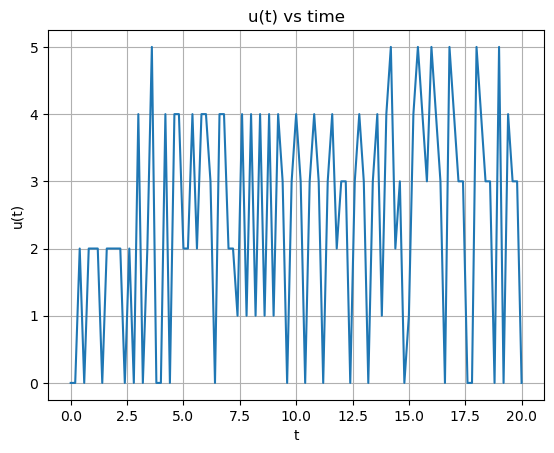

In [90]:
x = np.linspace(0, T, N+1)
plt.plot(x, u_t)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

## Last Trajectory


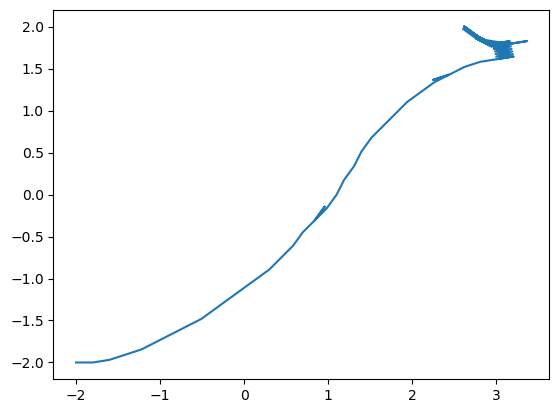

In [91]:
obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.show()

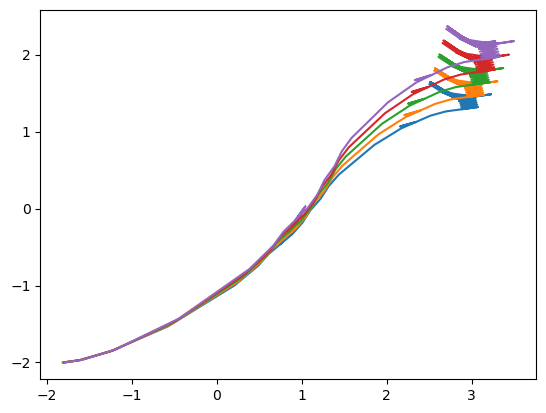

In [92]:
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
plt.show()

## Best Trajectory

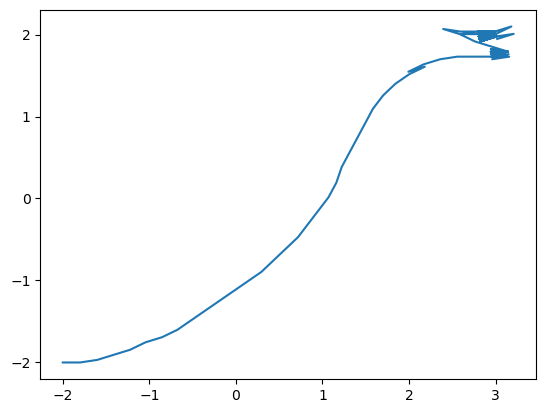

In [93]:
obs=np.array(best_obs)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.show()

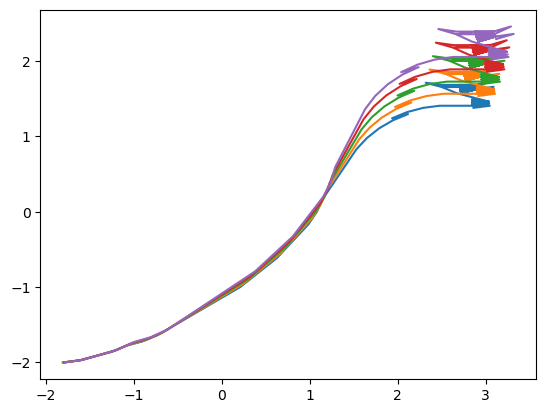

In [94]:
for i in range(num_system):
    obs=np.array(best_pos[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
plt.show()

## Pure Exploitation Trajectory

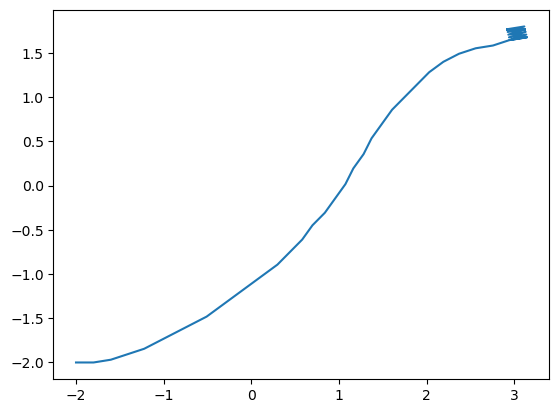

In [95]:
position=np.array([[-2,-2,0],[-2,-2,0],[-2,-2,0],[-2,-2,0],[-2,-2,0]])
observation=observe(position)
u_t=[]
observation_t=[observation]
position_t=[[] for i in range(5)]

for time in range(N+1):           
    candidates_u=[]
    for i in range(6):
        cand, _ = gpr_list[i].predict(observation.reshape(-1,5), return_std=True)
        candidates_u.append(cand[0])
    #print(candidates_u)
    u_k = decide_u_exploitation(observation,np.array(candidates_u))
    position_new = next_step(position,action_set[u_k])
    observation_new = observe(position_new)
    r = reward(observation_new)
    '''
    if explo:
        history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
        history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
    '''
    observation=observation_new
    position=position_new
    u_t.append(u_k)
    observation_t.append(observation)
    for i in range(num_system):
        position_t[i].append(position[i])
    '''
    if time%((N+1)//3+1)==0:
        for i in range(6):
            gpr_list[i]=GaussianProcessRegressor(alpha=1e-8).fit(history_su[i], history_r[i].reshape(-1,1))
    '''
    if r>100-0.03:
        break
    
obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.show()

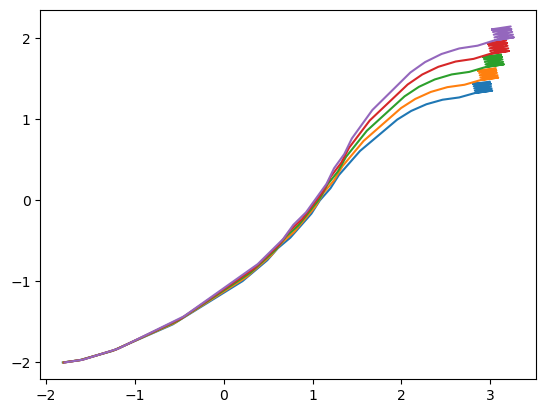

In [96]:
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
plt.show()

In [97]:
print(observation_t[-1])

[ 3.11913285e+00  1.76925575e+00 -3.33066907e-17  6.89831201e-03
  5.68002824e-02]


In [98]:
a=[1,2,4,8]
a[1:3]

[2, 4]